In [1]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

### Dataset Citation

<b> Link: https://ai.stanford.edu/~amaas/data/sentiment/ </b>

@InProceedings{maas-EtAl:2011:ACL-HLT2011,
  author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
  title     = {Learning Word Vectors for Sentiment Analysis},
  booktitle = {Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies},
  month     = {June},
  year      = {2011},
  address   = {Portland, Oregon, USA},
  publisher = {Association for Computational Linguistics},
  pages     = {142--150},
  url       = {http://www.aclweb.org/anthology/P11-1015}
}
<br> <br>

### Import Libraries

In [2]:
# import libraries

import re
import glob
import time
import pickle
import string
import warnings
import itertools
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing
from sklearn import utils
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
from multiprocessing import Pool
from sklearn.utils import shuffle
import sklearn.metrics as metrics
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

warnings.filterwarnings('ignore')

### Import Training Datasets

In [3]:
# define function to transform txt files to dataframes

def process(file_list):
    
    review_list = []
    
    for file in file_list:
        temp = open(file, 'r')
        review = temp.read()
        temp.close()
        review_list.append(review)
    
    return review_list

In [4]:
# import positive dataset and negative dataset
# Courtesy: https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory

pfile_list = glob.glob("train/pos/*.txt")
nfile_list = glob.glob("train/neg/*.txt")

print("total positive (training) reviews: ", len(pfile_list))
print("total negative (training) reviews: ", len(nfile_list))


pdf = pd.DataFrame(process(pfile_list), columns=['reviews'])
pdf['label'] = 1

ndf = pd.DataFrame(process(nfile_list), columns=['reviews'])
ndf['label'] = 0

total positive (training) reviews:  12500
total negative (training) reviews:  12500


In [5]:
# Exploratory Data Analysis

frame = [pdf, ndf]
df1 = pd.concat(frame)

print(df1['label'].value_counts())
print('\n')
print(df1.info())

1    12500
0    12500
Name: label, dtype: int64


<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 0 to 12499
Data columns (total 2 columns):
reviews    25000 non-null object
label      25000 non-null int64
dtypes: int64(1), object(1)
memory usage: 585.9+ KB
None


In [6]:
# import positive dataset and negative dataset
# Courtesy: https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory

ptest_list = glob.glob("test/pos/*.txt")
ntest_list = glob.glob("test/neg/*.txt")

print("total positive (training) reviews: ", len(ptest_list))
print("total negative (training) reviews: ", len(ntest_list))

p_test = pd.DataFrame(process(ptest_list), columns=['reviews'])
p_test['label'] = 1

n_test = pd.DataFrame(process(ntest_list), columns=['reviews'])
n_test['label'] = 0

total positive (training) reviews:  12500
total negative (training) reviews:  12500


In [7]:
# Exploratory Data Analysis

frame = [p_test, n_test]
df_test = pd.concat(frame)
print(df_test['label'].value_counts())
print('\n')
print(df_test.info())

1    12500
0    12500
Name: label, dtype: int64


<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 0 to 12499
Data columns (total 2 columns):
reviews    25000 non-null object
label      25000 non-null int64
dtypes: int64(1), object(1)
memory usage: 585.9+ KB
None


### Text Pre-Processing

In [8]:
# Pre-Requisite 1: Stopwords

# lengthy way of removing single character from the text
stopwords_dict = stopwords.words('english')
char_stopwords = ['a','b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 
                 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
stopwords_dict.extend(char_stopwords)

# Pre-Requisite 2: Lemmetization
# Courtesy of Gaurav Gupta : https://medium.com/@gaurav5430/using-nltk-for-lemmatizing-sentences-c1bfff963258

lemmatizer = WordNetLemmatizer()

def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None


def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [9]:
# Text Pre-Processing Function (Stemming)
# Decision 01 - Remove numerical value, simply text

# MultiProcessing
print("CPU available: ", multiprocessing.cpu_count())

st = PorterStemmer()

def preprocess_func(text):
    text = text.lower()
    text = re.compile(r'<[^>]+>').sub('', text) # remove html tags
    text = re.compile("[^a-zA-Z ]").sub('', text) # remove special character
    text = re.sub(r'\s+', ' ', text) # remove extra space           
    text = re.compile(r'\b(' + r'|'.join(stopwords_dict) + r')\b\s*').sub('', text) # remove stopwords
    text = lemmatize_sentence(text)
    return " ".join([st.stem(i) for i in text.split()])


# Function for MultiProcessing
def func(temp):
    temp = preprocess_func(temp)
    return temp

CPU available:  72


In [10]:
def cv_performance(clf, X, y, k=5):
    
    accuracy  = []
    precision = []
    recall    = []
    f1_list   = []
    rocauc    = []
    
    skf = StratifiedKFold(n_splits=k, random_state=None)
    
    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        
        accuracy.append(accuracy_score(y_val, y_pred))
        precision.append(precision_score(y_val, y_pred))
        recall.append(recall_score(y_val, y_pred))
        f1_list.append(f1_score(y_val, y_pred))
        rocauc.append(roc_auc_score(y_val, y_pred))
    
    print("Validation Accuracy Score   : ", np.array(accuracy).mean())
    print("Validation Precision Score  : ", np.array(precision).mean())
    print("Validation Recall Score     : ", np.array(recall).mean())
    print("Validation F1-Score         : ", np.array(f1_list).mean())
    print("Validation ROC-AUC Score    : ", np.array(rocauc).mean())

    return np.array(accuracy).mean()

In [11]:
# Test Accuracy Function

def test_accuracy(clf, X_train, y_train, X_test, y_test):

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    print("y Testing    : ")
    print(collections.Counter(y_test))
    
    print("y Prediction : ")
    print(collections.Counter(y_pred))
    
    print("Testing Accuracy Score   : ", accuracy_score(y_test, y_pred))   
    print("Testing ROC-AUC Score    : ", roc_auc_score(y_test, y_pred))
    print("Confusion Matrix ")
    print(confusion_matrix(y_test, y_pred))
    
    return y_pred

# Version 1.1 - Monogram, Occurrence of Words

In [12]:
# Version 1.1 - Occurence of Words (Monogram)
# Clean Data 1_11 Review List

df1_11_review_list = df1['reviews'].values.tolist()
print(len(df1_11_review_list))

p = Pool(72)
processed_list = p.map(func, df1_11_review_list)
print('Text Pre-Processing Done.')

# Version 1.1 - Occurence of Words (Monogram)

mono_occurence     = CountVectorizer(binary=True)
mono_occurence_bow = mono_occurence.fit_transform(np.array(processed_list)) # bow: bag-of-words
df1_11     = pd.DataFrame(mono_occurence_bow.toarray(), columns=mono_occurence.get_feature_names())

print(df1_11.shape)

25000
Text Pre-Processing Done.
(25000, 108593)


In [13]:
# Decision 01 - Drop Any Column with Sum Value Less Than 2

df1_11 = df1_11[df1_11.columns[df1_11.sum() > 1]]
print(df1_11.shape)

(25000, 36931)


In [14]:
# Prepare Data for Training | Validation Purpose

y1_11 = df1["label"].copy()
X1_11 = df1_11.copy()

print(y1_11.shape)
print(X1_11.shape)

(25000,)
(25000, 36931)


### Algorithms Overview: <br>

    [1] Logistic Regression 
    [2] Gaussian Naïve Bayes Classifier 
    [3] Bernoulli Naïve Bayes Classifier 
    [4] Multinomial Naïve Bayes Classifier 
    [5] Decision Tree Classifier 
    [6] XGBoost Classifier 

### Logistic Regression

In [15]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression
    
lr_acc_list = [] 
start_time   = time.time()
C_param_range = [0.01, 0.05, 0.075, 0.1,0.125, 0.15, 0.2, 0.25]

for param in C_param_range:
    print("parameter : ", param)
    lr_clf = LogisticRegression(penalty='l2', C=param, random_state=42)
    lr_acc = cv_performance(lr_clf, X1_11, y1_11, k=2)
    lr_acc_list.append(lr_acc)
    print("time : ", ((time.time() - start_time)/60), " mins")

parameter :  0.01
Validation Accuracy Score   :  0.86132
Validation Precision Score  :  0.8515584588266552
Validation Recall Score     :  0.8752
Validation F1-Score         :  0.8632045748709936
Validation ROC-AUC Score    :  0.86132
time :  0.5787570317586263  mins
parameter :  0.05
Validation Accuracy Score   :  0.86856
Validation Precision Score  :  0.8606529111016381
Validation Recall Score     :  0.87952
Validation F1-Score         :  0.8699756467081363
Validation ROC-AUC Score    :  0.86856
time :  1.1598487377166748  mins
parameter :  0.075
Validation Accuracy Score   :  0.869
Validation Precision Score  :  0.8620266650567258
Validation Recall Score     :  0.87864
Validation F1-Score         :  0.8702429540866281
Validation ROC-AUC Score    :  0.869
time :  1.7459426045417785  mins
parameter :  0.1
Validation Accuracy Score   :  0.86928
Validation Precision Score  :  0.8628017857868672
Validation Recall Score     :  0.8782399999999999
Validation F1-Score         :  0.87043497835

Text(0, 0.5, 'Cross-Validated Accuracy')

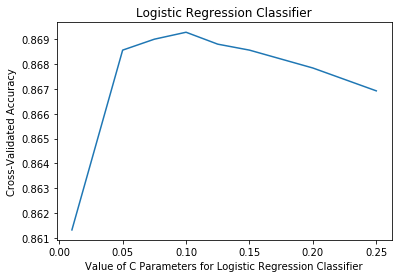

In [16]:
# Plot Accuracy (Logistic Regression)

plt.plot(C_param_range, lr_acc_list)
plt.title('Logistic Regression Classifier')
plt.xlabel('Value of C Parameters for Logistic Regression Classifier')
plt.ylabel('Cross-Validated Accuracy')

### Gaussian Naïve Bayes Classifier

In [17]:
# Gaussian NB
# Parameter Tuning

from sklearn.naive_bayes import GaussianNB

gnb_acc_list = [] 
start_time   = time.time()
gparam_range  = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4] 

for param in gparam_range:
    print("parameter : ", param)
    gnb_clf = GaussianNB(var_smoothing=param)
    gnb_acc = cv_performance(gnb_clf, X1_11, y1_11)
    gnb_acc_list.append(gnb_acc)
    print("time : ", ((time.time() - start_time)/60), " mins")

parameter :  1e-10
Validation Accuracy Score   :  0.65628
Validation Precision Score  :  0.718934662391003
Validation Recall Score     :  0.51328
Validation F1-Score         :  0.5988892895932423
Validation ROC-AUC Score    :  0.65628
time :  3.1445304195086163  mins
parameter :  1e-09
Validation Accuracy Score   :  0.6606399999999999
Validation Precision Score  :  0.7203962142437622
Validation Recall Score     :  0.5252
Validation F1-Score         :  0.607445644536071
Validation ROC-AUC Score    :  0.66064
time :  6.289880311489105  mins
parameter :  1e-08
Validation Accuracy Score   :  0.6657599999999999
Validation Precision Score  :  0.7216280408330255
Validation Recall Score     :  0.53984
Validation F1-Score         :  0.6175791998514212
Validation ROC-AUC Score    :  0.6657599999999999
time :  9.435712122917176  mins
parameter :  1e-07
Validation Accuracy Score   :  0.67172
Validation Precision Score  :  0.7216962611593217
Validation Recall Score     :  0.5591200000000001
Validat

Text(0, 0.5, 'Cross-Validated Accuracy')

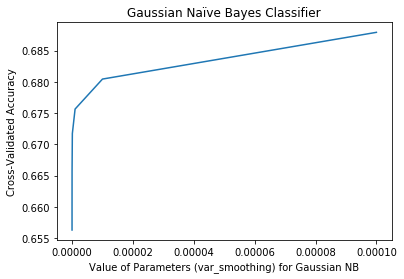

In [18]:
# Plot Accuracy (Gaussian NB)

plt.plot(gparam_range, gnb_acc_list)
plt.title('Gaussian Naïve Bayes Classifier')
plt.xlabel('Value of Parameters (var_smoothing) for Gaussian NB')
plt.ylabel('Cross-Validated Accuracy')

### Bernoulli Naïve Bayes Classifier

In [19]:
# Bernoulli NB
# Parameter Tuning

from sklearn.naive_bayes import BernoulliNB

bnb_acc_list = [] 
start_time   = time.time()
param_range  = [0.0, 1.0, 2.0, 3.0] 

for param in param_range:
    print("parameter : ", param)
    bnb_clf = BernoulliNB(alpha=param)
    bnb_acc = cv_performance(bnb_clf, X1_11, y1_11)
    bnb_acc_list.append(bnb_acc)
    print("time : ", ((time.time() - start_time)/60), " mins")

parameter :  0.0
Validation Accuracy Score   :  0.76632
Validation Precision Score  :  0.7731308189766961
Validation Recall Score     :  0.7539999999999999
Validation F1-Score         :  0.7634031107167811
Validation ROC-AUC Score    :  0.76632
time :  3.9901611248652142  mins
parameter :  1.0
Validation Accuracy Score   :  0.8414400000000001
Validation Precision Score  :  0.8680011368093599
Validation Recall Score     :  0.8053600000000001
Validation F1-Score         :  0.8354855567318837
Validation ROC-AUC Score    :  0.8414400000000001
time :  7.977990249792735  mins
parameter :  2.0
Validation Accuracy Score   :  0.8406799999999999
Validation Precision Score  :  0.8694915662922582
Validation Recall Score     :  0.80168
Validation F1-Score         :  0.8341848027743557
Validation ROC-AUC Score    :  0.8406799999999999
time :  11.964006805419922  mins
parameter :  3.0
Validation Accuracy Score   :  0.83988
Validation Precision Score  :  0.8700947450672827
Validation Recall Score     

Text(0, 0.5, 'Cross-Validated Accuracy')

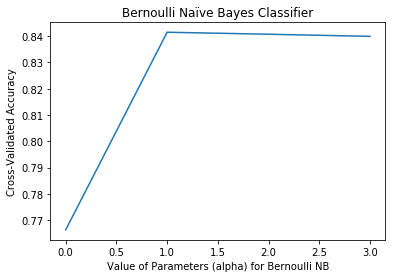

In [20]:
# Plot Accuracy (Bernoulli NB)

plt.plot(param_range, bnb_acc_list)
plt.title('Bernoulli Naïve Bayes Classifier')
plt.xlabel('Value of Parameters (alpha) for Bernoulli NB')
plt.ylabel('Cross-Validated Accuracy')

### Multinomial Naïve Bayes Classifier

In [21]:
# Multinomial NB
# Parameter Tuning

from sklearn.naive_bayes import MultinomialNB

mnb_acc_list = [] 
start_time   = time.time()
param_range  = [0.0, 1.0, 2.0, 3.0] 

for param in param_range:
    print("parameter : ", param)
    mnb_clf = MultinomialNB(alpha=param)
    mnb_acc = cv_performance(mnb_clf, X1_11, y1_11)
    mnb_acc_list.append(mnb_acc)
    print("time : ", ((time.time() - start_time)/60), " mins")

parameter :  0.0
Validation Accuracy Score   :  0.77172
Validation Precision Score  :  0.7727385242789189
Validation Recall Score     :  0.77
Validation F1-Score         :  0.7713190562714377
Validation ROC-AUC Score    :  0.77172
time :  0.8216027975082397  mins
parameter :  1.0
Validation Accuracy Score   :  0.8521599999999999
Validation Precision Score  :  0.8669388294793666
Validation Recall Score     :  0.8320000000000001
Validation F1-Score         :  0.8490901739640002
Validation ROC-AUC Score    :  0.8521599999999999
time :  1.6456535617510477  mins
parameter :  2.0
Validation Accuracy Score   :  0.85152
Validation Precision Score  :  0.8671386005627373
Validation Recall Score     :  0.8302399999999999
Validation F1-Score         :  0.8482692430364152
Validation ROC-AUC Score    :  0.85152
time :  2.4647573630015054  mins
parameter :  3.0
Validation Accuracy Score   :  0.8515599999999999
Validation Precision Score  :  0.8679439983851097
Validation Recall Score     :  0.82928000

Text(0, 0.5, 'Cross-Validated Mean Accuracy')

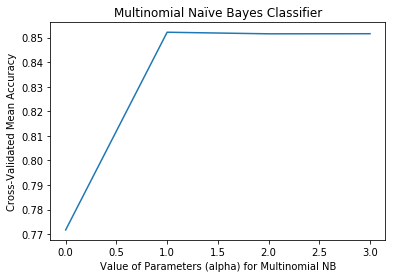

In [22]:
# Plot Accuracy (Multinomial NB)

plt.plot(param_range, mnb_acc_list)
plt.title('Multinomial Naïve Bayes Classifier')
plt.xlabel('Value of Parameters (alpha) for Multinomial NB')
plt.ylabel('Cross-Validated Mean Accuracy')

### Decision Tree Classifier

In [23]:
# Decision Tree Classifier
# Parameter Tuning 

from sklearn.tree import DecisionTreeClassifier

dt_acc_list = [] 
start_time   = time.time()
dt_range  = [1, 5, 10, 15, 20, 25, 30]

for param in dt_range:
    print("depth : ", param)
    dt_clf = DecisionTreeClassifier(max_depth=param, random_state=42)
    dt_acc = cv_performance(dt_clf, X1_11, y1_11)
    dt_acc_list.append(dt_acc)
    print("time : ", ((time.time() - start_time)/60), " mins")

depth :  1
Validation Accuracy Score   :  0.65076
Validation Precision Score  :  0.6055793451545759
Validation Recall Score     :  0.8648
Validation F1-Score         :  0.7123288927826517
Validation ROC-AUC Score    :  0.65076
time :  0.7686067581176758  mins
depth :  5
Validation Accuracy Score   :  0.7094400000000001
Validation Precision Score  :  0.6649060458038075
Validation Recall Score     :  0.8444800000000001
Validation F1-Score         :  0.7440091679719398
Validation ROC-AUC Score    :  0.7094400000000001
time :  2.252549576759338  mins
depth :  10
Validation Accuracy Score   :  0.73444
Validation Precision Score  :  0.6992428930821609
Validation Recall Score     :  0.82288
Validation F1-Score         :  0.7559986949141246
Validation ROC-AUC Score    :  0.73444
time :  4.5333816369374595  mins
depth :  15
Validation Accuracy Score   :  0.73632
Validation Precision Score  :  0.7021708065958794
Validation Recall Score     :  0.82088
Validation F1-Score         :  0.756819370285

Text(0, 0.5, 'Cross-Validated Mean Accuracy')

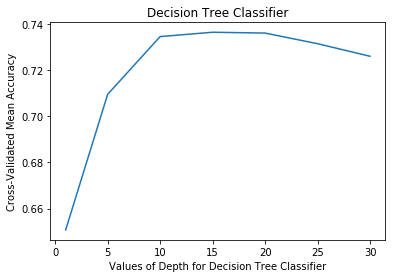

In [25]:
# Plot Accuracy (Decision Tree)

plt.plot(dt_range, dt_acc_list)
plt.title('Decision Tree Classifier')
plt.xlabel('Values of Depth for Decision Tree Classifier')
plt.ylabel('Cross-Validated Mean Accuracy')

### XGBoost Classifier

In [26]:
!pip install xgboost

    100% |████████████████████████████████| 142.8MB 392kB/s  eta 0:00:01    78% |█████████████████████████▏      | 112.4MB 101.8MB/s eta 0:00:01
fastai 1.0.52 requires nvidia-ml-py3, which is not installed.
thinc 6.12.1 has requirement msgpack<0.6.0,>=0.5.6, but you'll have msgpack 0.6.0 which is incompatible.
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [27]:
# XGBoost Model
from xgboost import XGBClassifier

start_time    = time.time()
xgb_clf = XGBClassifier()
xgb_acc = cv_performance(xgb_clf, X1_11, y1_11, k=2)
print("time : ", ((time.time() - start_time)/60), " mins")

Validation Accuracy Score   :  0.7984
Validation Precision Score  :  0.7693973819958551
Validation Recall Score     :  0.85224
Validation F1-Score         :  0.8087021418492188
Validation ROC-AUC Score    :  0.7984
time :  24.024915194511415  mins


### Note to Readers:

I would like to apologies in advance. <br>
Originally, I plan to include kNN, SGD, SVM & AdaBoost in the analysis. <br>
However, these algorithms took way too much time than I originally anticipated (large sample size), which led me to my decision to drop them. <br>
With that being said, let's jump right into Version 1.2 ! <br>
<br>

# Version 1.2 - Monogram, Word Count

In [32]:
# Version 1.2 - Word Count (Monogram)

mono_wordcount     = CountVectorizer(binary=False)
mono_wordcount_bow = mono_wordcount.fit_transform(np.array(processed_list)) # bow: bag-of-words
df1_12     = pd.DataFrame(mono_wordcount_bow.toarray(), columns=mono_wordcount.get_feature_names())

print(df1_12.shape)

(25000, 108593)


In [33]:
# Decision 01 - Drop Any Column with Sum Value Less Than 2

df1_12 = df1_12[df1_12.columns[df1_12.sum() > 1]]
print(df1_12.shape)

(25000, 38868)


In [37]:
y1_12 = df1["label"].copy()
X1_12 = df1_12.copy()

print(y1_12.shape)
print(X1_12.shape)

(25000,)
(25000, 38868)


### Logistic Regression

In [40]:
lr_acc_list = [] 
start_time   = time.time()
C_param_range = [0.01, 0.05, 0.075, 0.1, 0.2, 0.3]

for param in C_param_range:
    print("parameter : ", param)
    lr_clf = LogisticRegression(penalty='l2', C=param, random_state=42)
    lr_acc = cv_performance(lr_clf, X1_12, y1_12, k=2)
    lr_acc_list.append(lr_acc)
    print("time : ", ((time.time() - start_time)/60), " mins")

parameter :  0.01
Validation Accuracy Score   :  0.86572
Validation Precision Score  :  0.8551247238271735
Validation Recall Score     :  0.88064
Validation F1-Score         :  0.8676723681140462
Validation ROC-AUC Score    :  0.86572
time :  0.6212227821350098  mins
parameter :  0.05
Validation Accuracy Score   :  0.87312
Validation Precision Score  :  0.8645642180114188
Validation Recall Score     :  0.88488
Validation F1-Score         :  0.8745836112061711
Validation ROC-AUC Score    :  0.8731199999999999
time :  1.2446386814117432  mins
parameter :  0.075
Validation Accuracy Score   :  0.8728
Validation Precision Score  :  0.865011271171176
Validation Recall Score     :  0.8835200000000001
Validation F1-Score         :  0.8741383129940717
Validation ROC-AUC Score    :  0.8728
time :  1.8695732673009238  mins
parameter :  0.1
Validation Accuracy Score   :  0.8722799999999999
Validation Precision Score  :  0.8650538412501507
Validation Recall Score     :  0.8822399999999999
Validatio

Text(0, 0.5, 'Cross-Validated Accuracy')

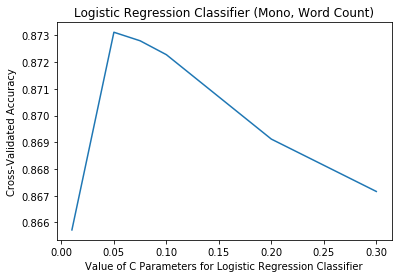

In [41]:
# Plot Accuracy (Logistic Regression)

plt.plot(C_param_range, lr_acc_list)
plt.title('Logistic Regression Classifier (Mono, Word Count)')
plt.xlabel('Value of C Parameters for Logistic Regression Classifier')
plt.ylabel('Cross-Validated Accuracy')

### Gaussian Naïve Bayes Classifier

In [47]:
from sklearn.naive_bayes import GaussianNB

gnb_acc_list = [] 
start_time   = time.time()
gparam_range  = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3] 

for param in gparam_range:
    print("parameter : ", param)
    gnb_clf = GaussianNB(var_smoothing=param)
    gnb_acc = cv_performance(gnb_clf, X1_12, y1_12, k=3)
    gnb_acc_list.append(gnb_acc)
    print("time : ", ((time.time() - start_time)/60), " mins")

parameter :  1e-05
Validation Accuracy Score   :  0.7049198234088464
Validation Precision Score  :  0.7370819797019489
Validation Recall Score     :  0.6372806546095612
Validation F1-Score         :  0.6835076182449327
Validation ROC-AUC Score    :  0.7049198234088466
time :  1.8281762282053629  mins
parameter :  5e-05
Validation Accuracy Score   :  0.7267600541068573
Validation Precision Score  :  0.8124349339308331
Validation Recall Score     :  0.5898408396171321
Validation F1-Score         :  0.683367053578599
Validation ROC-AUC Score    :  0.7267600541068573
time :  3.6573757092158  mins
parameter :  0.0001
Validation Accuracy Score   :  0.7159202875867866
Validation Precision Score  :  0.8295846915275439
Validation Recall Score     :  0.5435209350318706
Validation F1-Score         :  0.6566834334390842
Validation ROC-AUC Score    :  0.7159202875867866
time :  5.485408389568329  mins
parameter :  0.0005
Validation Accuracy Score   :  0.6708801654004981
Validation Precision Score  

Text(0, 0.5, 'Cross-Validated Accuracy')

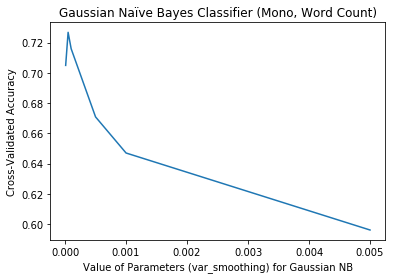

In [48]:
# Plot Accuracy (Gaussian NB)

plt.plot(gparam_range, gnb_acc_list)
plt.title('Gaussian Naïve Bayes Classifier (Mono, Word Count)')
plt.xlabel('Value of Parameters (var_smoothing) for Gaussian NB')
plt.ylabel('Cross-Validated Accuracy')

### Bernoulli Naïve Bayes Classifier

In [49]:
from sklearn.naive_bayes import BernoulliNB

bnb_acc_list = [] 
start_time   = time.time()
param_range  = [0.0, 0.5, 0.75, 1.0, 2.0, 3.0] 

for param in param_range:
    print("parameter : ", param)
    bnb_clf = BernoulliNB(alpha=param)
    bnb_acc = cv_performance(bnb_clf, X1_12, y1_12, k=3)
    bnb_acc_list.append(bnb_acc)
    print("time : ", ((time.time() - start_time)/60), " mins")

parameter :  0.0
Validation Accuracy Score   :  0.7615201057559178
Validation Precision Score  :  0.7687049727594873
Validation Recall Score     :  0.7482404768156233
Validation F1-Score         :  0.7583142286331498
Validation ROC-AUC Score    :  0.7615201057559178
time :  2.6622183163960775  mins
parameter :  0.5
Validation Accuracy Score   :  0.8400000875590058
Validation Precision Score  :  0.8649407674044194
Validation Recall Score     :  0.8058401319253078
Validation F1-Score         :  0.8343295173384973
Validation ROC-AUC Score    :  0.8400000875590058
time :  5.330359570185343  mins
parameter :  0.75
Validation Accuracy Score   :  0.8406000491636137
Validation Precision Score  :  0.8662527101985401
Validation Recall Score     :  0.8056001127206991
Validation F1-Score         :  0.834804557812797
Validation ROC-AUC Score    :  0.8406000491636137
time :  7.999300356705984  mins
parameter :  1.0
Validation Accuracy Score   :  0.8407200971689908
Validation Precision Score  :  0.86

Text(0, 0.5, 'Cross-Validated Accuracy')

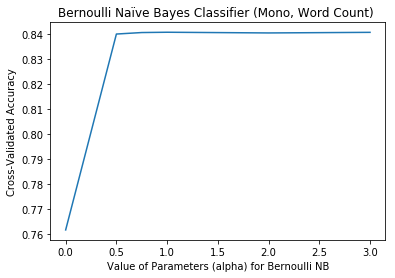

In [50]:
# Plot Accuracy (Bernoulli NB)

plt.plot(param_range, bnb_acc_list)
plt.title('Bernoulli Naïve Bayes Classifier (Mono, Word Count) ')
plt.xlabel('Value of Parameters (alpha) for Bernoulli NB')
plt.ylabel('Cross-Validated Accuracy')

### Multinomial Naïve Bayes Classifier

In [53]:
from sklearn.naive_bayes import MultinomialNB

mnb_acc_list = [] 
start_time   = time.time()
param_range  = [0.0, 0.25, 0.5, 0.75, 1.0, 1.5]  

for param in param_range:
    print("parameter : ", param)
    mnb_clf = MultinomialNB(alpha=param)
    mnb_acc = cv_performance(mnb_clf, X1_12, y1_12)
    mnb_acc_list.append(mnb_acc)
    print("time : ", ((time.time() - start_time)/60), " mins")

parameter :  0.0
Validation Accuracy Score   :  0.77956
Validation Precision Score  :  0.7820043945913704
Validation Recall Score     :  0.7752800000000001
Validation F1-Score         :  0.778610941045865
Validation ROC-AUC Score    :  0.77956
time :  0.9299917737642924  mins
parameter :  0.25
Validation Accuracy Score   :  0.84968
Validation Precision Score  :  0.8641783193797512
Validation Recall Score     :  0.82976
Validation F1-Score         :  0.8466032774119212
Validation ROC-AUC Score    :  0.8496799999999999
time :  1.8606145143508912  mins
parameter :  0.5
Validation Accuracy Score   :  0.85024
Validation Precision Score  :  0.8654993213259539
Validation Recall Score     :  0.82936
Validation F1-Score         :  0.8470305887607008
Validation ROC-AUC Score    :  0.85024
time :  2.7910583933194477  mins
parameter :  0.75
Validation Accuracy Score   :  0.8502000000000001
Validation Precision Score  :  0.8661556691359495
Validation Recall Score     :  0.8283999999999999
Validatio

Text(0, 0.5, 'Cross-Validated Mean Accuracy')

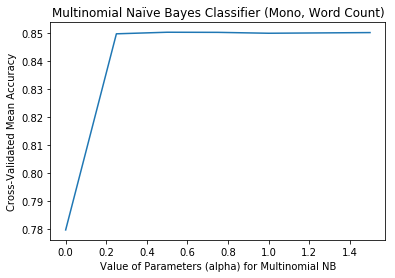

In [54]:
# Plot Accuracy (Multinomial NB)

plt.plot(param_range, mnb_acc_list)
plt.title('Multinomial Naïve Bayes Classifier (Mono, Word Count)')
plt.xlabel('Value of Parameters (alpha) for Multinomial NB')
plt.ylabel('Cross-Validated Mean Accuracy')

### Decision Tree Classifier 

In [55]:
# Decision Tree Classifier
# Parameter Tuning 

from sklearn.tree import DecisionTreeClassifier

dt_acc_list = [] 
start_time   = time.time()
dt_range  = [1, 5, 10, 15, 20, 25, 30]

for param in dt_range:
    print("depth : ", param)
    dt_clf = DecisionTreeClassifier(max_depth=param, random_state=42)
    dt_acc = cv_performance(dt_clf, X1_12, y1_12)
    dt_acc_list.append(dt_acc)
    print("time : ", ((time.time() - start_time)/60), " mins")

depth :  1
Validation Accuracy Score   :  0.65076
Validation Precision Score  :  0.6055793451545759
Validation Recall Score     :  0.8648
Validation F1-Score         :  0.7123288927826517
Validation ROC-AUC Score    :  0.65076
time :  0.8189746022224427  mins
depth :  5
Validation Accuracy Score   :  0.7098800000000001
Validation Precision Score  :  0.6639297343765345
Validation Recall Score     :  0.85032
Validation F1-Score         :  0.7455607709679422
Validation ROC-AUC Score    :  0.7098800000000001
time :  2.4004443407058718  mins
depth :  10
Validation Accuracy Score   :  0.7352799999999999
Validation Precision Score  :  0.7001521563711526
Validation Recall Score     :  0.82304
Validation F1-Score         :  0.7566284645957966
Validation ROC-AUC Score    :  0.7352799999999999
time :  4.807361725966135  mins
depth :  15
Validation Accuracy Score   :  0.734
Validation Precision Score  :  0.7019936446865369
Validation Recall Score     :  0.81336
Validation F1-Score         :  0.753

Text(0, 0.5, 'Cross-Validated Mean Accuracy')

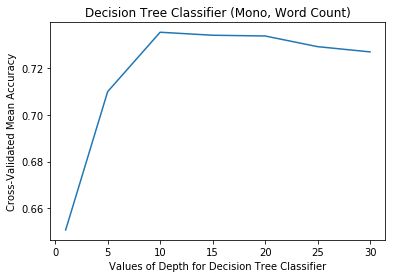

In [56]:
# Plot Accuracy (Decision Tree)

plt.plot(dt_range, dt_acc_list)
plt.title('Decision Tree Classifier (Mono, Word Count)')
plt.xlabel('Values of Depth for Decision Tree Classifier')
plt.ylabel('Cross-Validated Mean Accuracy')

### XGBoost Classifier

In [57]:
from xgboost import XGBClassifier

start_time    = time.time()
xgb_clf = XGBClassifier()
xgb_acc = cv_performance(xgb_clf, X1_12, y1_12, k=2)
print("time : ", ((time.time() - start_time)/60), " mins")

Validation Accuracy Score   :  0.80048
Validation Precision Score  :  0.7701205144013576
Validation Recall Score     :  0.8567199999999999
Validation F1-Score         :  0.8111110553382597
Validation ROC-AUC Score    :  0.8004799999999999
time :  25.424437979857128  mins


# Version 1.3 - Monogram, Term-Frequency 
<br>

In [58]:
# Version 1.3 - Term Frequency (Monogram)

mono_tf     = CountVectorizer(binary=False)
mono_tf_bow = mono_tf.fit_transform(np.array(processed_list)) # bow: bag-of-words
df1_13     = pd.DataFrame(mono_tf_bow.toarray(), columns=mono_tf.get_feature_names())

print(df1_13.shape)

(25000, 108593)


In [59]:
# Total Terms 
total = df1_13.to_numpy().sum()
print(total)

2997138


In [60]:
# Divide term count/total terms (term-frequency)
df1_13 = df1_13.div(total)

y1_13 = df1["label"].copy()
X1_13 = df1_13.copy()

print(y1_13.shape)
print(X1_13.shape)

(25000,)
(25000, 108593)


### Logistic Regression

In [61]:
from sklearn.linear_model import LogisticRegression

lr_acc_list = [] 
start_time   = time.time()
C_param_range = [0.05, 0.075, 0.1, 0.5, 1]

for param in C_param_range:
    print("parameter : ", param)
    lr_clf = LogisticRegression(penalty='l2', C=param, random_state=42)
    lr_acc = cv_performance(lr_clf, X1_13, y1_13, k=2)
    lr_acc_list.append(lr_acc)
    print("time : ", ((time.time() - start_time)/60), " mins")

parameter :  0.05
Validation Accuracy Score   :  0.69336
Validation Precision Score  :  0.7844459551656489
Validation Recall Score     :  0.53384
Validation F1-Score         :  0.6350488396086567
Validation ROC-AUC Score    :  0.6933600000000001
time :  1.5622446934382122  mins
parameter :  0.075
Validation Accuracy Score   :  0.69572
Validation Precision Score  :  0.7225094497295477
Validation Recall Score     :  0.66056
Validation F1-Score         :  0.680218526632768
Validation ROC-AUC Score    :  0.6957199999999999
time :  3.1119592587153115  mins
parameter :  0.1
Validation Accuracy Score   :  0.6956800000000001
Validation Precision Score  :  0.7223368419468479
Validation Recall Score     :  0.66072
Validation F1-Score         :  0.6802429664313789
Validation ROC-AUC Score    :  0.6956800000000001
time :  4.6584478656450905  mins
parameter :  0.5
Validation Accuracy Score   :  0.6934400000000001
Validation Precision Score  :  0.7846923312191469
Validation Recall Score     :  0.533

Text(0, 0.5, 'Cross-Validated Accuracy')

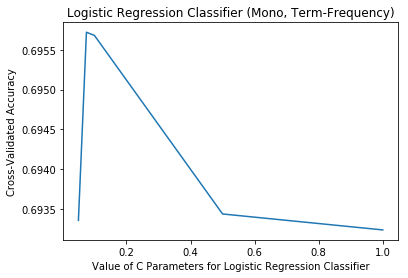

In [62]:
# Plot Accuracy (Logistic Regression)

plt.plot(C_param_range, lr_acc_list)
plt.title('Logistic Regression Classifier (Mono, Term-Frequency)')
plt.xlabel('Value of C Parameters for Logistic Regression Classifier')
plt.ylabel('Cross-Validated Accuracy')

### Gaussian Naïve Bayes Classifier

In [68]:
from sklearn.naive_bayes import GaussianNB

gnb_acc_list = [] 
start_time   = time.time()
gparam_range  = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1] 

for param in gparam_range:
    print("parameter : ", param)
    gnb_clf = GaussianNB(var_smoothing=param)
    gnb_acc = cv_performance(gnb_clf, X1_13, y1_13, k=2)
    gnb_acc_list.append(gnb_acc)
    print("time : ", ((time.time() - start_time)/60), " mins")

parameter :  1e-05
Validation Accuracy Score   :  0.692
Validation Precision Score  :  0.7231793341035024
Validation Recall Score     :  0.62216
Validation F1-Score         :  0.6688727860198955
Validation ROC-AUC Score    :  0.692
time :  2.863401929537455  mins
parameter :  5e-05
Validation Accuracy Score   :  0.71968
Validation Precision Score  :  0.8031542131258608
Validation Recall Score     :  0.5820000000000001
Validation F1-Score         :  0.6749113520836754
Validation ROC-AUC Score    :  0.7196800000000001
time :  5.724912345409393  mins
parameter :  0.0001
Validation Accuracy Score   :  0.70872
Validation Precision Score  :  0.8199837070214626
Validation Recall Score     :  0.53488
Validation F1-Score         :  0.6474114273704819
Validation ROC-AUC Score    :  0.70872
time :  8.582732518513998  mins
parameter :  0.0005
Validation Accuracy Score   :  0.6664
Validation Precision Score  :  0.8423926992032035
Validation Recall Score     :  0.40944
Validation F1-Score         : 

Text(0, 0.5, 'Cross-Validated Accuracy')

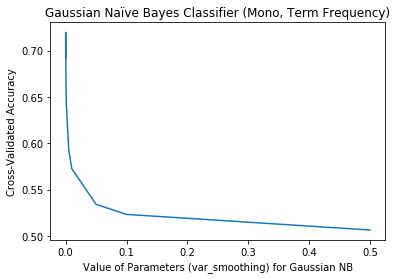

In [69]:
# Plot Accuracy (Gaussian NB)

plt.plot(gparam_range, gnb_acc_list)
plt.title('Gaussian Naïve Bayes Classifier (Mono, Term Frequency)')
plt.xlabel('Value of Parameters (var_smoothing) for Gaussian NB')
plt.ylabel('Cross-Validated Accuracy')

### Bernoulli Naïve Bayes Classifier

In [70]:
from sklearn.naive_bayes import BernoulliNB

bnb_acc_list = [] 
start_time   = time.time()
param_range  = [0.0, 0.5, 0.75, 1.0, 2.0, 3.0] 

for param in param_range:
    print("parameter : ", param)
    bnb_clf = BernoulliNB(alpha=param)
    bnb_acc = cv_performance(bnb_clf, X1_13, y1_13, k=3)
    bnb_acc_list.append(bnb_acc)
    print("time : ", ((time.time() - start_time)/60), " mins")

parameter :  0.0
Validation Accuracy Score   :  0.7614000961536135
Validation Precision Score  :  0.7688223108386182
Validation Recall Score     :  0.7476804448058942
Validation F1-Score         :  0.7580848400375236
Validation ROC-AUC Score    :  0.7614000961536136
time :  7.314589901765188  mins
parameter :  0.5
Validation Accuracy Score   :  0.839800055553885
Validation Precision Score  :  0.8655758080002515
Validation Recall Score     :  0.8045600807048254
Validation F1-Score         :  0.8339370142634124
Validation ROC-AUC Score    :  0.839800055553885
time :  14.734104851881662  mins
parameter :  0.75
Validation Accuracy Score   :  0.8405200363615655
Validation Precision Score  :  0.8671141969791006
Validation Recall Score     :  0.8043200615002167
Validation F1-Score         :  0.8345151920421124
Validation ROC-AUC Score    :  0.8405200363615655
time :  22.070009620984397  mins
parameter :  1.0
Validation Accuracy Score   :  0.8404000747631019
Validation Precision Score  :  0.86

Text(0, 0.5, 'Cross-Validated Accuracy')

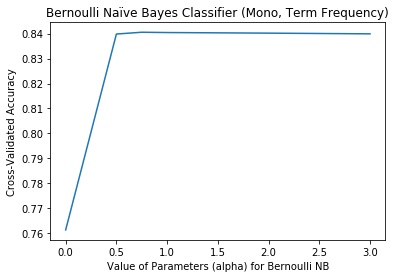

In [71]:
# Plot Accuracy (Bernoulli NB)

plt.plot(param_range, bnb_acc_list)
plt.title('Bernoulli Naïve Bayes Classifier (Mono, Term Frequency)')
plt.xlabel('Value of Parameters (alpha) for Bernoulli NB')
plt.ylabel('Cross-Validated Accuracy')

### Multinomial Naïve Bayes Classifier

In [72]:
from sklearn.naive_bayes import MultinomialNB

mnb_acc_list = [] 
start_time   = time.time()
param_range  = [0.0, 0.25, 0.5, 0.75, 1.0, 1.5]  

for param in param_range:
    print("parameter : ", param)
    mnb_clf = MultinomialNB(alpha=param)
    mnb_acc = cv_performance(mnb_clf, X1_13, y1_13, k=3)
    mnb_acc_list.append(mnb_acc)
    print("time : ", ((time.time() - start_time)/60), " mins")

parameter :  0.0
Validation Accuracy Score   :  0.8167197896371844
Validation Precision Score  :  0.8287654666502385
Validation Recall Score     :  0.7983996901947316
Validation F1-Score         :  0.8132922095153007
Validation ROC-AUC Score    :  0.8167197896371844
time :  0.8240289012591044  mins
parameter :  0.25
Validation Accuracy Score   :  0.6923999128557474
Validation Precision Score  :  0.7855288429964024
Validation Recall Score     :  0.5332780482698206
Validation F1-Score         :  0.6331464427245949
Validation ROC-AUC Score    :  0.6923999128557473
time :  1.637724256515503  mins
parameter :  0.5
Validation Accuracy Score   :  0.6917998936465303
Validation Precision Score  :  0.7849766538691255
Validation Recall Score     :  0.5323180098544589
Validation F1-Score         :  0.6322486958451088
Validation ROC-AUC Score    :  0.6917998936465303
time :  2.4857418060302736  mins
parameter :  0.75
Validation Accuracy Score   :  0.6917199192475548
Validation Precision Score  :  0

Text(0, 0.5, 'Cross-Validated Mean Accuracy')

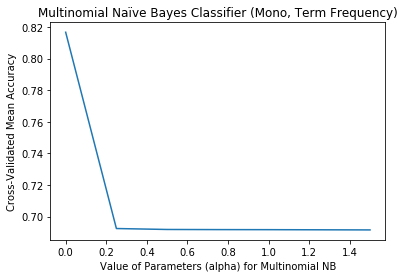

In [73]:
# Plot Accuracy (Multinomial NB)

plt.plot(param_range, mnb_acc_list)
plt.title('Multinomial Naïve Bayes Classifier (Mono, Term Frequency)')
plt.xlabel('Value of Parameters (alpha) for Multinomial NB')
plt.ylabel('Cross-Validated Mean Accuracy')

### Decision Tree Classifier

In [74]:
# Decision Tree Classifier
# Parameter Tuning 

from sklearn.tree import DecisionTreeClassifier

dt_acc_list = [] 
start_time   = time.time()
dt_range  = [1, 5, 10, 15, 20, 25, 30]

for param in dt_range:
    print("depth : ", param)
    dt_clf = DecisionTreeClassifier(max_depth=param, random_state=42)
    dt_acc = cv_performance(dt_clf, X1_13, y1_13)
    dt_acc_list.append(dt_acc)
    print("time : ", ((time.time() - start_time)/60), " mins")

depth :  1
Validation Accuracy Score   :  0.65076
Validation Precision Score  :  0.6055793451545759
Validation Recall Score     :  0.8648
Validation F1-Score         :  0.7123288927826517
Validation ROC-AUC Score    :  0.65076
time :  1.855936082204183  mins
depth :  5
Validation Accuracy Score   :  0.7098000000000001
Validation Precision Score  :  0.6638457244035079
Validation Recall Score     :  0.85032
Validation F1-Score         :  0.7455074394951907
Validation ROC-AUC Score    :  0.7098
time :  5.513712267080943  mins
depth :  10
Validation Accuracy Score   :  0.73484
Validation Precision Score  :  0.6993882178269734
Validation Recall Score     :  0.82376
Validation F1-Score         :  0.7564834685041494
Validation ROC-AUC Score    :  0.7348399999999999
time :  10.805342861016591  mins
depth :  15
Validation Accuracy Score   :  0.73472
Validation Precision Score  :  0.7027867334173689
Validation Recall Score     :  0.8136800000000001
Validation F1-Score         :  0.75409898738151

Text(0, 0.5, 'Cross-Validated Mean Accuracy')

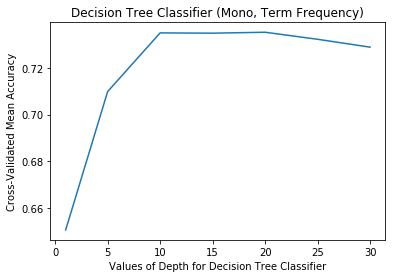

In [75]:
# Plot Accuracy (Decision Tree)

plt.plot(dt_range, dt_acc_list)
plt.title('Decision Tree Classifier (Mono, Term Frequency)')
plt.xlabel('Values of Depth for Decision Tree Classifier')
plt.ylabel('Cross-Validated Mean Accuracy')

# Version 1.4 - Monogram, TF-IDF
<br>

In [76]:
# Version 1.4 - TF-iDF (Monogram)
from sklearn.feature_extraction.text import TfidfVectorizer

mono_tfidf     = TfidfVectorizer()
mono_tfidf.fit(processed_list)
mono_tfidf_bow = mono_tfidf.transform(processed_list)# bow: bag-of-words
df1_14     = pd.DataFrame(mono_tfidf_bow.toarray(), columns=mono_tfidf.get_feature_names())

print(df1_14.shape)

(25000, 108593)


In [77]:
y1_14 = df1["label"].copy()
X1_14 = df1_14.copy()

print(y1_14.shape)
print(X1_14.shape)

(25000,)
(25000, 108593)


### Logistic Regression

In [78]:
from sklearn.linear_model import LogisticRegression

lr_acc_list = [] 
start_time   = time.time()
C_param_range = [0.01, 0.05, 0.075, 0.1, 0.5, 1]

for param in C_param_range:
    print("parameter : ", param)
    lr_clf = LogisticRegression(penalty='l2', C=param, random_state=42)
    lr_acc = cv_performance(lr_clf, X1_14, y1_14, k=2)
    lr_acc_list.append(lr_acc)
    print("time : ", ((time.time() - start_time)/60), " mins")

parameter :  0.01
Validation Accuracy Score   :  0.8104
Validation Precision Score  :  0.7806297762379544
Validation Recall Score     :  0.86344
Validation F1-Score         :  0.8199359346173709
Validation ROC-AUC Score    :  0.8104
time :  1.6710967659950255  mins
parameter :  0.05
Validation Accuracy Score   :  0.8336399999999999
Validation Precision Score  :  0.8059295853253676
Validation Recall Score     :  0.87896
Validation F1-Score         :  0.8408298202147926
Validation ROC-AUC Score    :  0.8336399999999999
time :  3.5201661427815756  mins
parameter :  0.075
Validation Accuracy Score   :  0.842
Validation Precision Score  :  0.816339274881065
Validation Recall Score     :  0.88256
Validation F1-Score         :  0.8481336479135323
Validation ROC-AUC Score    :  0.842
time :  5.334029126167297  mins
parameter :  0.1
Validation Accuracy Score   :  0.84704
Validation Precision Score  :  0.8232206689881678
Validation Recall Score     :  0.88392
Validation F1-Score         :  0.852

Text(0, 0.5, 'Cross-Validated Accuracy')

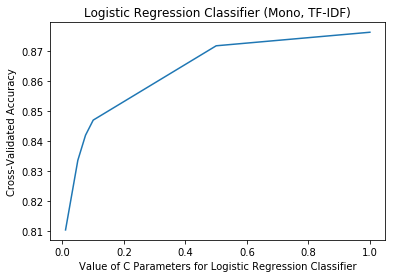

In [79]:
# Plot Accuracy (Logistic Regression)

plt.plot(C_param_range, lr_acc_list)
plt.title('Logistic Regression Classifier (Mono, TF-IDF)')
plt.xlabel('Value of C Parameters for Logistic Regression Classifier')
plt.ylabel('Cross-Validated Accuracy')

### Gaussian Naïve Bayes Classifier

In [80]:
from sklearn.naive_bayes import GaussianNB

gnb_acc_list = [] 
start_time   = time.time()
gparam_range  = [0.01, 0.05, 0.075, 0.1, 0.2, 0.3, 0.4, 0.5] 

for param in gparam_range:
    print("parameter : ", param)
    gnb_clf = GaussianNB(var_smoothing=param)
    gnb_acc = cv_performance(gnb_clf, X1_14, y1_14, k=2)
    gnb_acc_list.append(gnb_acc)
    print("time : ", ((time.time() - start_time)/60), " mins")

parameter :  0.01
Validation Accuracy Score   :  0.80568
Validation Precision Score  :  0.7952591467050432
Validation Recall Score     :  0.82352
Validation F1-Score         :  0.8090733709060978
Validation ROC-AUC Score    :  0.80568
time :  3.544257966677348  mins
parameter :  0.05
Validation Accuracy Score   :  0.82048
Validation Precision Score  :  0.8281173563561095
Validation Recall Score     :  0.80904
Validation F1-Score         :  0.8183252914753231
Validation ROC-AUC Score    :  0.8204799999999999
time :  6.798989260196686  mins
parameter :  0.075
Validation Accuracy Score   :  0.82336
Validation Precision Score  :  0.8375570313054495
Validation Recall Score     :  0.80248
Validation F1-Score         :  0.8195026120050153
Validation ROC-AUC Score    :  0.82336
time :  9.842905155817668  mins
parameter :  0.1
Validation Accuracy Score   :  0.82388
Validation Precision Score  :  0.8428455404225869
Validation Recall Score     :  0.7963199999999999
Validation F1-Score         :  

Text(0, 0.5, 'Cross-Validated Accuracy')

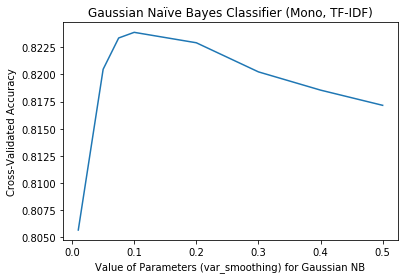

In [81]:
# Plot Accuracy (Gaussian NB)

plt.plot(gparam_range, gnb_acc_list)
plt.title('Gaussian Naïve Bayes Classifier (Mono, TF-IDF)')
plt.xlabel('Value of Parameters (var_smoothing) for Gaussian NB')
plt.ylabel('Cross-Validated Accuracy')

### Bernoulli Naïve Bayes Classifier

In [82]:
from sklearn.naive_bayes import BernoulliNB

bnb_acc_list = [] 
start_time   = time.time()
param_range  = [0.0, 0.5, 0.75, 1.0, 2.0, 3.0] 

for param in param_range:
    print("parameter : ", param)
    bnb_clf = BernoulliNB(alpha=param)
    bnb_acc = cv_performance(bnb_clf, X1_14, y1_14, k=3)
    bnb_acc_list.append(bnb_acc)
    print("time : ", ((time.time() - start_time)/60), " mins")

parameter :  0.0
Validation Accuracy Score   :  0.7614000961536135
Validation Precision Score  :  0.7688223108386182
Validation Recall Score     :  0.7476804448058942
Validation F1-Score         :  0.7580848400375236
Validation ROC-AUC Score    :  0.7614000961536136
time :  7.220603319009145  mins
parameter :  0.5
Validation Accuracy Score   :  0.839800055553885
Validation Precision Score  :  0.8655758080002515
Validation Recall Score     :  0.8045600807048254
Validation F1-Score         :  0.8339370142634124
Validation ROC-AUC Score    :  0.839800055553885
time :  14.50316287279129  mins
parameter :  0.75
Validation Accuracy Score   :  0.8405200363615655
Validation Precision Score  :  0.8671141969791006
Validation Recall Score     :  0.8043200615002167
Validation F1-Score         :  0.8345151920421124
Validation ROC-AUC Score    :  0.8405200363615655
time :  21.858243060112  mins
parameter :  1.0
Validation Accuracy Score   :  0.8404000747631019
Validation Precision Score  :  0.867771

Text(0, 0.5, 'Cross-Validated Accuracy')

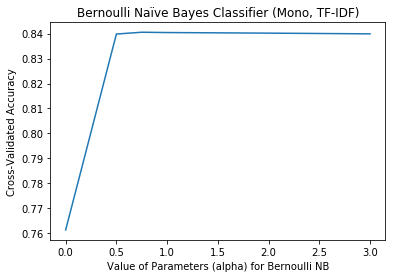

In [83]:
# Plot Accuracy (Bernoulli NB)

plt.plot(param_range, bnb_acc_list)
plt.title('Bernoulli Naïve Bayes Classifier (Mono, TF-IDF)')
plt.xlabel('Value of Parameters (alpha) for Bernoulli NB')
plt.ylabel('Cross-Validated Accuracy')

### Multinomial Naïve Bayes Classifier

In [84]:
from sklearn.naive_bayes import MultinomialNB

mnb_acc_list = [] 
start_time   = time.time()
param_range  = [0.0, 0.25, 0.5, 0.75, 1.0, 1.5]  

for param in param_range:
    print("parameter : ", param)
    mnb_clf = MultinomialNB(alpha=param)
    mnb_acc = cv_performance(mnb_clf, X1_14, y1_14, k=3)
    mnb_acc_list.append(mnb_acc)
    print("time : ", ((time.time() - start_time)/60), " mins")

parameter :  0.0
Validation Accuracy Score   :  0.7660798369927814
Validation Precision Score  :  0.7602098649055655
Validation Recall Score     :  0.7774402147684162
Validation F1-Score         :  0.7686833680529878
Validation ROC-AUC Score    :  0.7660798369927813
time :  0.9807265957196554  mins
parameter :  0.25
Validation Accuracy Score   :  0.8549198637320728
Validation Precision Score  :  0.8576552870169412
Validation Recall Score     :  0.8511193708439954
Validation F1-Score         :  0.8543582864545008
Validation ROC-AUC Score    :  0.8549198637320727
time :  1.9683523774147034  mins
parameter :  0.5
Validation Accuracy Score   :  0.8566797229433359
Validation Precision Score  :  0.8612919018987949
Validation Recall Score     :  0.8503191468158304
Validation F1-Score         :  0.855745084846916
Validation ROC-AUC Score    :  0.8566797229433359
time :  2.985334074497223  mins
parameter :  0.75
Validation Accuracy Score   :  0.857559623746663
Validation Precision Score  :  0.8

Text(0, 0.5, 'Cross-Validated Mean Accuracy')

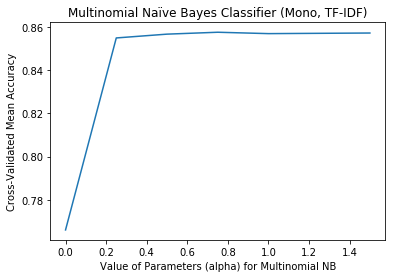

In [85]:
# Plot Accuracy (Multinomial NB)

plt.plot(param_range, mnb_acc_list)
plt.title('Multinomial Naïve Bayes Classifier (Mono, TF-IDF)')
plt.xlabel('Value of Parameters (alpha) for Multinomial NB')
plt.ylabel('Cross-Validated Mean Accuracy')

### Decision Tree Classifier

In [86]:
# Decision Tree Classifier
# Parameter Tuning 

from sklearn.tree import DecisionTreeClassifier

dt_acc_list = [] 
start_time   = time.time()
dt_range  = [1, 5, 10, 15, 20, 25, 30]

for param in dt_range:
    print("depth : ", param)
    dt_clf = DecisionTreeClassifier(max_depth=param, random_state=42)
    dt_acc = cv_performance(dt_clf, X1_14, y1_14)
    dt_acc_list.append(dt_acc)
    print("time : ", ((time.time() - start_time)/60), " mins")

depth :  1
Validation Accuracy Score   :  0.64924
Validation Precision Score  :  0.6009966060984906
Validation Recall Score     :  0.88856
Validation F1-Score         :  0.7169806350108721
Validation ROC-AUC Score    :  0.64924
time :  2.2234689553578693  mins
depth :  5
Validation Accuracy Score   :  0.70756
Validation Precision Score  :  0.6570261616938673
Validation Recall Score     :  0.8686399999999999
Validation F1-Score         :  0.7481036147920461
Validation ROC-AUC Score    :  0.7075600000000001
time :  5.949194236596425  mins
depth :  10
Validation Accuracy Score   :  0.7314400000000001
Validation Precision Score  :  0.6913724427700653
Validation Recall Score     :  0.8362400000000001
Validation F1-Score         :  0.7569154009514284
Validation ROC-AUC Score    :  0.7314400000000001
time :  11.009175582726796  mins
depth :  15
Validation Accuracy Score   :  0.73068
Validation Precision Score  :  0.6943805665209171
Validation Recall Score     :  0.82408
Validation F1-Score   

Text(0, 0.5, 'Cross-Validated Mean Accuracy')

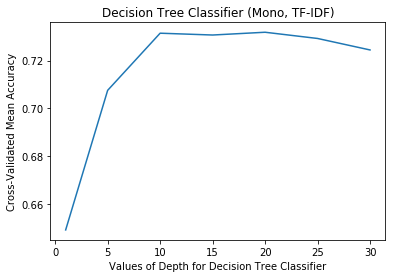

In [87]:
# Plot Accuracy (Decision Tree)

plt.plot(dt_range, dt_acc_list)
plt.title('Decision Tree Classifier (Mono, TF-IDF)')
plt.xlabel('Values of Depth for Decision Tree Classifier')
plt.ylabel('Cross-Validated Mean Accuracy')

### XGBoost Classifier

In [90]:
from xgboost import XGBClassifier

start_time    = time.time()
xgb_clf = XGBClassifier()
xgb_acc = cv_performance(xgb_clf, X1_14, y1_14, k=2)
print("time : ", ((time.time() - start_time)/60), " mins")

Validation Accuracy Score   :  0.8004
Validation Precision Score  :  0.7688071133907869
Validation Recall Score     :  0.8592
Validation F1-Score         :  0.811492257484815
Validation ROC-AUC Score    :  0.8003999999999999
time :  74.04849356015524  mins


In [93]:
# Done